# Project 1: computing all kinematic informations of a real manipulator

In this project (and the next ones), we will build all the necessary various functionalities for realistic robot manipulators. This first project aims to build the core fonctions (basic homogeneous transforms, twists, forward kinematics and Jacobians) that will be a foundation for all subsequent algorithms.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a written answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.


## The robot

We will use a model of the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa). This robot has 7 revolute joints and its kinematics is described in the picture below:

![](https://raw.githubusercontent.com/righetti/ROB6003/143afa17d7eb1af79c3f6ce034973a1774da5d42/Project1/kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [ ]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project1'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project1/')
    os.chdir('/content/ROB6003/Project1/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [1]:
import numpy as np
import robot_visualizer
from scipy.linalg import logm, expm
import time

import matplotlib.pyplot as plt
%matplotlib inline

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7000/static/


# Displaying an arbitrary configuration

You can use the following function to display arbitrary configurations of the robot

In [2]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.40431379 0.70511548 0.58362568 0.48090796 0.6960558  0.18025208
 0.25131965]


## Question 1: basics
In this first set of questions, we aim to write the basic functions to do kinematics
* Write a function ``vec_to_skew(w)`` that transforms a 3D vector (numpy array) into a skew symmetric matrix
* Write a function ``twist_to_skew(V)`` that transforms a 6D twist into a 4x4 matrix (use ``vec_to_skew``)
* Write a function ``exp_twist_bracket(V)`` that returns the exponential of a (bracketed) twist $\mathrm{e}^{[\mathcal{V}]}$ where the input to the function is a 6D twist
* Write a function ``inverseT(T)`` that returns the inverse of a homogeneous transform T
* Write a function ``getAdjoint(T)`` that returns the adjoint of a homogeneous transform T

In [3]:
def vec_to_skew(w):
        return np.array([[0, -w[2], w[1]], 
                         [w[2], 0, -w[0]], 
                         [-w[1], w[0], 0]])

def twist_to_skew(V):
    n = np.zeros((3,1))
    n = np.array([[V.item(0)],[V.item(1)],[V.item(2)]])
    Vans = np.zeros((4,4))
    Vans[0:3,0:3]=vec_to_skew(n)
    Vans[0:3,3:4]=np.array([[V.item(3)],[V.item(4)],[V.item(5)]])
    return Vans

def exp_twist_bracket(V):
   Vts = twist_to_skew(V)
   Ans = expm(Vts)
   return Ans

def inverseT(T):
    InvT = np.linalg.inv(T)
    return InvT

def getAdjoint(T):
    P = np.array([[T.item(0,3)],[T.item(1,3)],[T.item(2,3)]])
    SkewP = vec_to_skew(P)
    SkewPR = np.matmul(SkewP,T[0:3,0:3])
    AdjT = np.zeros((6,6))
    AdjT[0:3,0:3] = T[0:3,0:3]
    AdjT[3:6,0:3] = SkewPR
    AdjT[0:3,3:6] = np.zeros((3,3))
    AdjT[3:6,3:6] = T[0:3,0:3]
    return AdjT




## Question 2: forward kinematics
* Write a function ``forward_kinematics(theta)`` that gets as an input an array of joint angles and computes the pose of the end-effector.

In order to test this function, you are given the following forward kinematics results (up to $10^{-4}$ precision),

$T_{SH}(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 1.301 \end{bmatrix}$,

$T_{SH}(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
-0.4951 & -0.814 &  0.3037 & -0.0003 \\
0.6286 & -0.5769 & -0.5215 &  0.0056\\
0.5997 & -0.0673 &  0.7974 &  1.2563\\
0.  &    0.  &    0.  &    1.\end{bmatrix}$

$T_{SH}(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
-0.9669 & -0.254 &  -0.0234 &  0.1535\\
0.0976 & -0.2835 & -0.954 &  -0.7557\\
0.2357 & -0.9247 &  0.2989 &  0.795\\
 0.  &    0.  &    0.  &    1.\end{bmatrix}$

In [4]:
def forward_kinematics(theta):
  
    s1 = np.zeros((6,1))
    w1 = np.array([[0],[0],[1]])
    p1 = np.array([[0],[0],[0.1575]])
    v1 = np.matmul(-vec_to_skew(w1),p1)
    s1[0:3,0:1] = w1
    s1[3:6,0:1] = v1

    s2 = np.zeros((6,1))
    p2 = ([[0],[0],[0.1575+0.2025]])
    w2 = np.array([[0],[1],[0]])
    v2 = np.matmul(-vec_to_skew(w2),p2)
    s2[0:3,0:1] = w2
    s2[3:6,0:1] = v2

    s3 = np.zeros((6,1))
    p3 = ([[0],[0],[0.1575+0.2025+0.2045]])
    w3 = np.array([[0],[0],[1]])
    v3 = np.matmul(-vec_to_skew(w3),p3)
    s3[0:3,0:1] = w3
    s3[3:6,0:1] = v3

    s4 = np.zeros((6,1))
    p4 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155]])
    w4 = np.array([[0],[-1],[0]])
    v4 = np.matmul(-vec_to_skew(w4),p4)
    s4[0:3,0:1] = w4
    s4[3:6,0:1] = v4

    s5 = np.zeros((6,1))
    p5 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845]])
    w5 = np.array([[0],[0],[1]])
    v5 = np.matmul(-vec_to_skew(w5),p5)
    s5[0:3,0:1] = w5
    s5[3:6,0:1] = v5

    s6 = np.zeros((6,1))
    p6 = ([[0],[-0.0607],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155]])
    w6 = np.array([[0],[1],[0]])
    v6 = np.matmul(-vec_to_skew(w6),p6)
    s6[0:3,0:1] = w6
    s6[3:6,0:1] = v6   

    s7 = np.zeros((6,1))
    p7 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810]])
    w7 = np.array([[0],[0],[1]])
    v7 = np.matmul(-vec_to_skew(w3),p3)
    s7[0:3,0:1] = w7
    s7[3:6,0:1] = v7 

    M = np.array([[1,0,0,0],[0,1,0,0],[0,0,1, 0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810+0.0400],[0,0,0,1]])

    S1 = exp_twist_bracket(s1*theta.item(0))
    S2 = exp_twist_bracket(s2*theta.item(1))
    S3 = exp_twist_bracket(s3*theta.item(2))
    S4 = exp_twist_bracket(s4*theta.item(3))
    S5 = exp_twist_bracket(s5*theta.item(4))
    S6 = exp_twist_bracket(s6*theta.item(5))
    S7 = exp_twist_bracket(s7*theta.item(6))

    T01 = np.matmul(S1,S2)
    T01 = np.matmul(T01,S3)
    T01 = np.matmul(T01,S4)
    T01 = np.matmul(T01,S5)
    T01 = np.matmul(T01,S6)
    T01 = np.matmul(T01,S7)
    T01 = np.matmul(T01,M)
    return T01  

## Question 3: jacobians
* Write a function ``get_space_jacobian(theta)`` that computes the space jacobian given an array of joint angles

In order to test this function, you are given the following space Jacobian results (up to $10^{-3}$ precision),
$J^S(0,\ 0,\ 0,\ 0,\ 0,\ 0,\ 0) = \begin{bmatrix}
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   1.000 &   0.000 & -1.000 &   0.000 &   1.000 &   0.000\\
   1.000 &   0.000 &   1.000 &   0.000 &   1.000 &   0.000 &   1.000\\
   0.000 & -0.360 &   0.000 &   0.780 &   0.000 & -1.180 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000\\
   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000 &   0.000
\end{bmatrix}
$,

$J^S(0.2,\ -0.2,\ 0.5,\ -0.4,\ 1.2,\ -0.8,\ 0.4) = \begin{bmatrix}
   0.000 & -0.199 & -0.195 &   0.635 &   0.112 & -0.943 &   0.304\\
   0.000 &   0.980 & -0.039 & -0.767 &   0.213 & -0.287 & -0.522\\
   1.000 &   0.000 &   0.980 &   0.095 &   0.971 &   0.172 &   0.797\\
   0.000 & -0.353 &   0.014 &   0.590 & -0.181 &   0.344 &   0.660\\
   0.000 & -0.072 & -0.070 &   0.498 &   0.166 & -1.087 &   0.382\\
   0.000 &   0.000 &   0.000 &   0.073 & -0.016 &   0.075 & -0.002
\end{bmatrix}$

$J^S(-1.2,\ 0.7,\ 2.8,\ 0.7,\ 1.2,\ 0.2,\ 0.3) = \begin{bmatrix}
   0.000 &   0.932 &   0.233 &   0.971 &   0.146 & -0.528 & -0.023\\
   0.000 &   0.362 & -0.600 &   0.103 & -0.970 & -0.242 & -0.954\\
   1.000 &   0.000 &   0.765 & -0.216 &   0.194 & -0.814 &   0.299\\
   0.000 & -0.130 &   0.216 & -0.015 &   0.612 &   0.705 &   0.533\\
   0.000 &   0.336 &   0.084 &   0.683 &   0.080 & -0.274 & -0.065\\
   0.000 &   0.000 &   0.000 &   0.255 & -0.058 & -0.376 & -0.164
\end{bmatrix}$

### Hint: Q2 and Q3
Depending on which method you use to compute the quantities of Q2 and Q3, you will need to define a series of fixed homogeneous transforms, screws, etc. You may want to store these values in various variables that you can reuse (i.e. define the fixed kinematic parameters once and for all).

You may also want to store some intermediate results to later compute the Jacobians.

Feel free to design the data structure that you prefer and to also pass additional parameters or return multiple variables with these functions if it simplifies your design. You can also put these functions in a class if you wish. Any solution is ok, as long as you can compute the requested quantities.

Make sure to explain your design in the report.

In [5]:
def get_space_jacobian(theta):
    s1 = np.zeros((6,1))
    w1 = np.array([[0],[0],[1]])
    p1 = np.array([[0],[0],[0.1575]])
    v1 = np.matmul(-vec_to_skew(w1),p1)
    s1[0:3,0:1] = w1
    s1[3:6,0:1] = v1

    s2 = np.zeros((6,1))
    p2 = ([[0],[0],[0.1575+0.2025]])
    w2 = np.array([[0],[1],[0]])
    v2 = np.matmul(-vec_to_skew(w2),p2)
    s2[0:3,0:1] = w2
    s2[3:6,0:1] = v2

    s3 = np.zeros((6,1))
    p3 = ([[0],[0],[0.1575+0.2025+0.2045]])
    w3 = np.array([[0],[0],[1]])
    v3 = np.matmul(-vec_to_skew(w3),p3)
    s3[0:3,0:1] = w3
    s3[3:6,0:1] = v3

    s4 = np.zeros((6,1))
    p4 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155]])
    w4 = np.array([[0],[-1],[0]])
    v4 = np.matmul(-vec_to_skew(w4),p4)
    s4[0:3,0:1] = w4
    s4[3:6,0:1] = v4

    s5 = np.zeros((6,1))
    p5 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845]])
    w5 = np.array([[0],[0],[1]])
    v5 = np.matmul(-vec_to_skew(w5),p5)
    s5[0:3,0:1] = w5
    s5[3:6,0:1] = v5

    s6 = np.zeros((6,1))
    p6 = ([[0],[-0.0607],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155]])
    w6 = np.array([[0],[1],[0]])
    v6 = np.matmul(-vec_to_skew(w6),p6)
    s6[0:3,0:1] = w6
    s6[3:6,0:1] = v6   

    s7 = np.zeros((6,1))
    p7 = ([[0],[0],[0.1575+0.2025+0.2045+0.2155+0.1845+0.2155+0.0810]])
    w7 = np.array([[0],[0],[1]])
    v7 = np.matmul(-vec_to_skew(w3),p3)
    s7[0:3,0:1] = w7
    s7[3:6,0:1] = v7

    S1 = exp_twist_bracket(s1*theta.item(0))
    S2 = exp_twist_bracket(s2*theta.item(1))
    S3 = exp_twist_bracket(s3*theta.item(2))
    S4 = exp_twist_bracket(s4*theta.item(3))
    S5 = exp_twist_bracket(s5*theta.item(4))
    S6 = exp_twist_bracket(s6*theta.item(5))

    Js1 = s1
    Js2 = np.matmul(getAdjoint(S1),s2)
    Js3 = np.matmul(getAdjoint(np.matmul(S1,S2)),s3)
    Js4 = np.matmul(getAdjoint(np.matmul(np.matmul(S1,S2),S3)),s4)
    Js5 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4)),s5)
    Js6 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4),S5)),s6)
    Js7 = np.matmul(getAdjoint(np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(S1,S2),S3),S4),S5),S6)),s7)

    Js = np.zeros((6,7))
    
    Js[0:6,0:1]=Js1
    Js[0:6,1:2]=Js2
    Js[0:6,2:3]=Js3
    Js[0:6,3:4]=Js4
    Js[0:6,4:5]=Js5
    Js[0:6,5:6]=Js6
    Js[0:6,6:7]=Js7

    return Js



## Question 4: displaying hand trajectories 
You are given a file ``joint_trajectory.npy`` which contains a sequence of 100 joint configurations (cf. below) corresponding to a motion of the robot over time.
* Compute the position of the hand (i.e. the origin of the frame H) in the spatial frame for all 100 joint configuration
* Plot x-y position of the hand for all the configurations (i.e. a 2D plot with x as the abscissa and y as the ordinate of the graph). What does the hand draw?
* Do the same analysis and plots for the x-z and y-z pairs.

### Hint
You may use (matplotlib)[https://matplotlib.org/] to draw plots

In [6]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_trajectory.npy', 'rb') as f:
    joint_trajectory = np.load(f)
    
# we display the trajectory
n_samples = joint_trajectory.shape[1]
xyz = np.zeros((3,n_samples))

for i in range(n_samples):
    robot_visualizer.display_robot(joint_trajectory[:,i])
    Tinst = forward_kinematics(joint_trajectory[:,i])
    xyz[0:3,i:i+1] = Tinst[0:3,3:4]

    time.sleep(0.05) # we wait between two displays so we can see each configuration

    

/tmp/ipykernel_30091/2796876803.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[0, -w[2], w[1]],


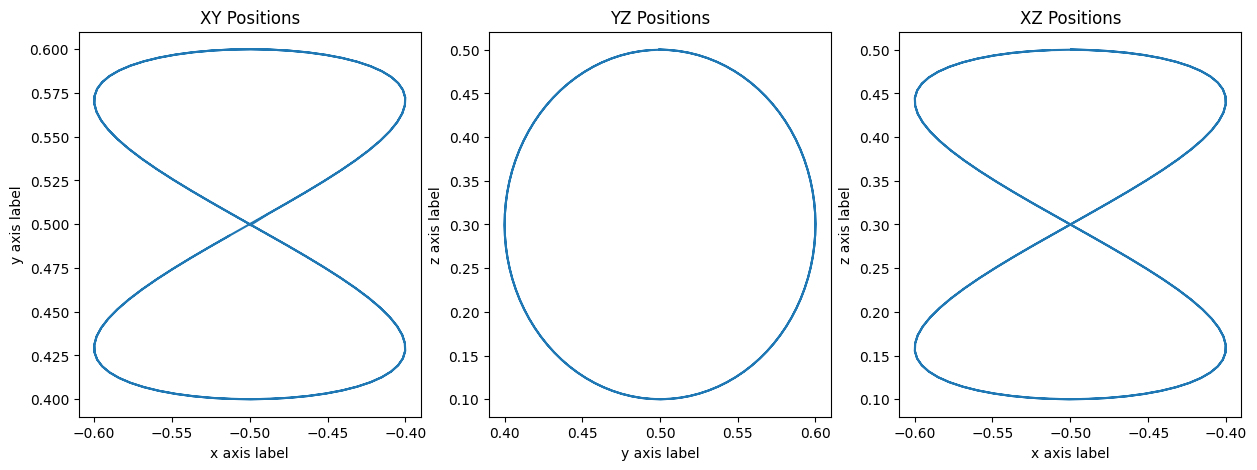

In [11]:
plt.figure(figsize=[15,5])
# %matplotlib widget

plt.subplot(1,3,1)
plt.plot(xyz[0,:],xyz[1,:])
plt.xlabel('x axis label')
plt.ylabel('y axis label')
plt.title('XY Positions')

plt.subplot(1,3,2)
plt.plot(xyz[1,:],xyz[2,:])
plt.xlabel('y axis label')
plt.ylabel('z axis label')
plt.title('YZ Positions')

plt.subplot(1,3,3)
plt.plot(xyz[0,:],xyz[2,:])
plt.xlabel('x axis label')
plt.ylabel('z axis label')
plt.title('XZ Positions')
plt.show()

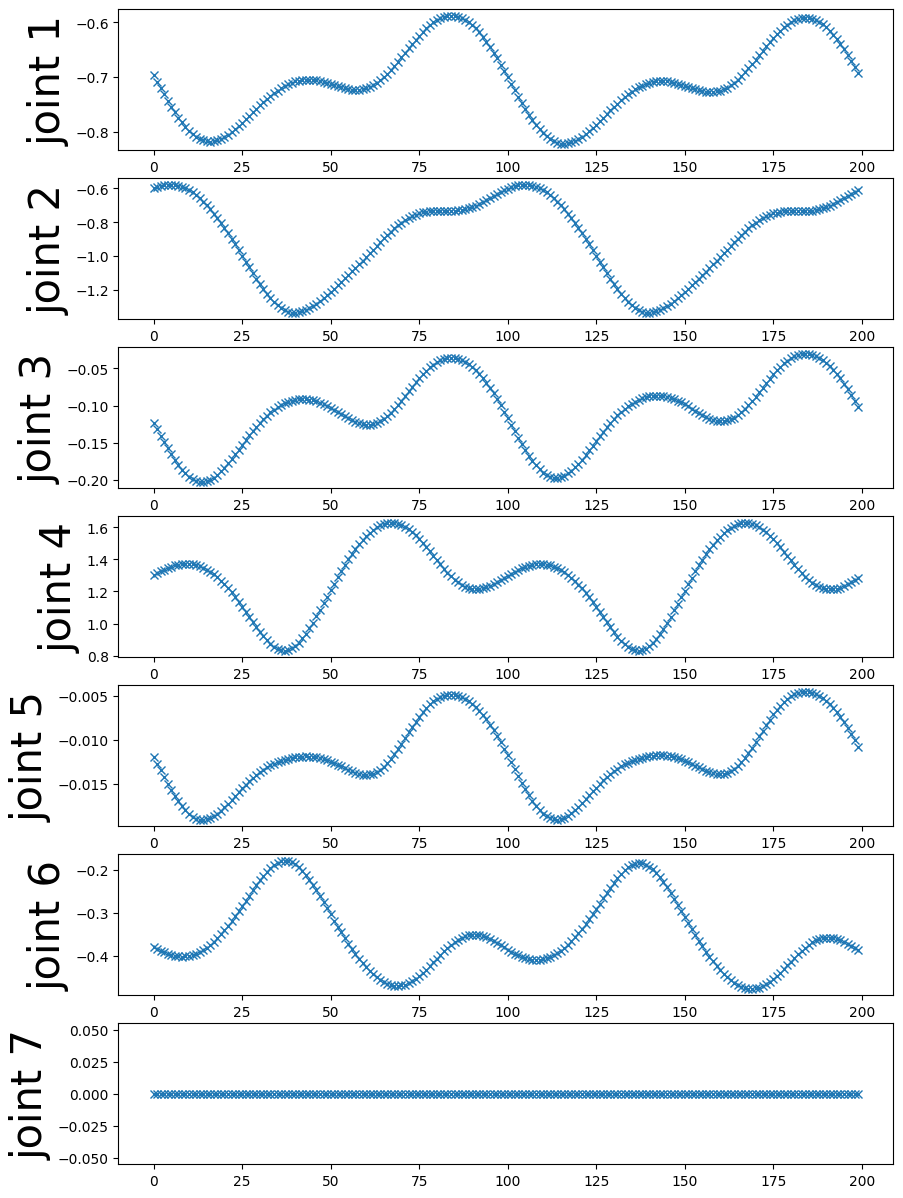

In [12]:
# now we plot the joint trajectories for each joint (each cross correspond to one data point)
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_trajectory[i,:], 'x', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)

## Question 5: computing velocities
The file ``joint_velocities.npy`` contains the velocities of each joint corresponding to the sequence joint configurations seen in the previous question. 
* Use the Jacobian to compute the linear velocity of the endeffector in: 1) the spatial frame. 2) the end-effector frame and 3) in a frame with same origin as the end-effector frame but oriented like the spatial frame
* Plot these velocities in each frame (one plot per dimension x,y,z)
* Compare these plots and relate them to the plot of the positions (Question 4), is there a frame that seems most intuitive to you? Why?

In [13]:
# we open the file and put all the data in the variable joint_trajectory 
# this gives us a 7 x 200 array (each column in one set of joint configurations)
with open('joint_velocity.npy', 'rb') as f:
    joint_velocities = np.load(f)
Vsxyz = np.zeros((3,n_samples))
Vbxyz = np.zeros((3,n_samples))
Vbexyz = np.zeros((3,n_samples))
Tbe = np.zeros((4,4))
Tbe[3:4,0::] = [0,0,0,1]
Tbe[0:3,0:3] = np.eye(3)

for i in range(n_samples):
    Jacobians = get_space_jacobian(joint_trajectory[:,i])
    Vels = np.matmul(Jacobians,joint_velocities[:,i])
    Vsxyz[0:3,i:i+1] = np.array([[Vels.item(3)],[Vels.item(4)],[Vels.item(5)]]) #Velocities in Spatial frame
    Tbs = inverseT(forward_kinematics(joint_trajectory[:,i]))
    Jacobianb = np.matmul(getAdjoint(Tbs),Jacobians)
    Velb = np.matmul(Jacobianb,joint_velocities[:,i])
    Vbxyz[0:3,i:i+1] = np.array([[Velb.item(3)],[Velb.item(4)],[Velb.item(5)]]) #Velocities in End-Effector frame
    Tbe[0:3,3:4] = forward_kinematics(joint_trajectory[:,i])[0:3,3:4] # Tbs[0:3,3:4]
    Tbe = inverseT(Tbe)
    Jacobianbe = np.matmul(getAdjoint(Tbe),Jacobians)
    Velbe = np.matmul(Jacobianbe,joint_velocities[:,i])
    Vbexyz[0:3,i:i+1] = np.array([[Velbe.item(3)],[Velbe.item(4)],[Velbe.item(5)]])



/tmp/ipykernel_30091/2796876803.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[0, -w[2], w[1]],


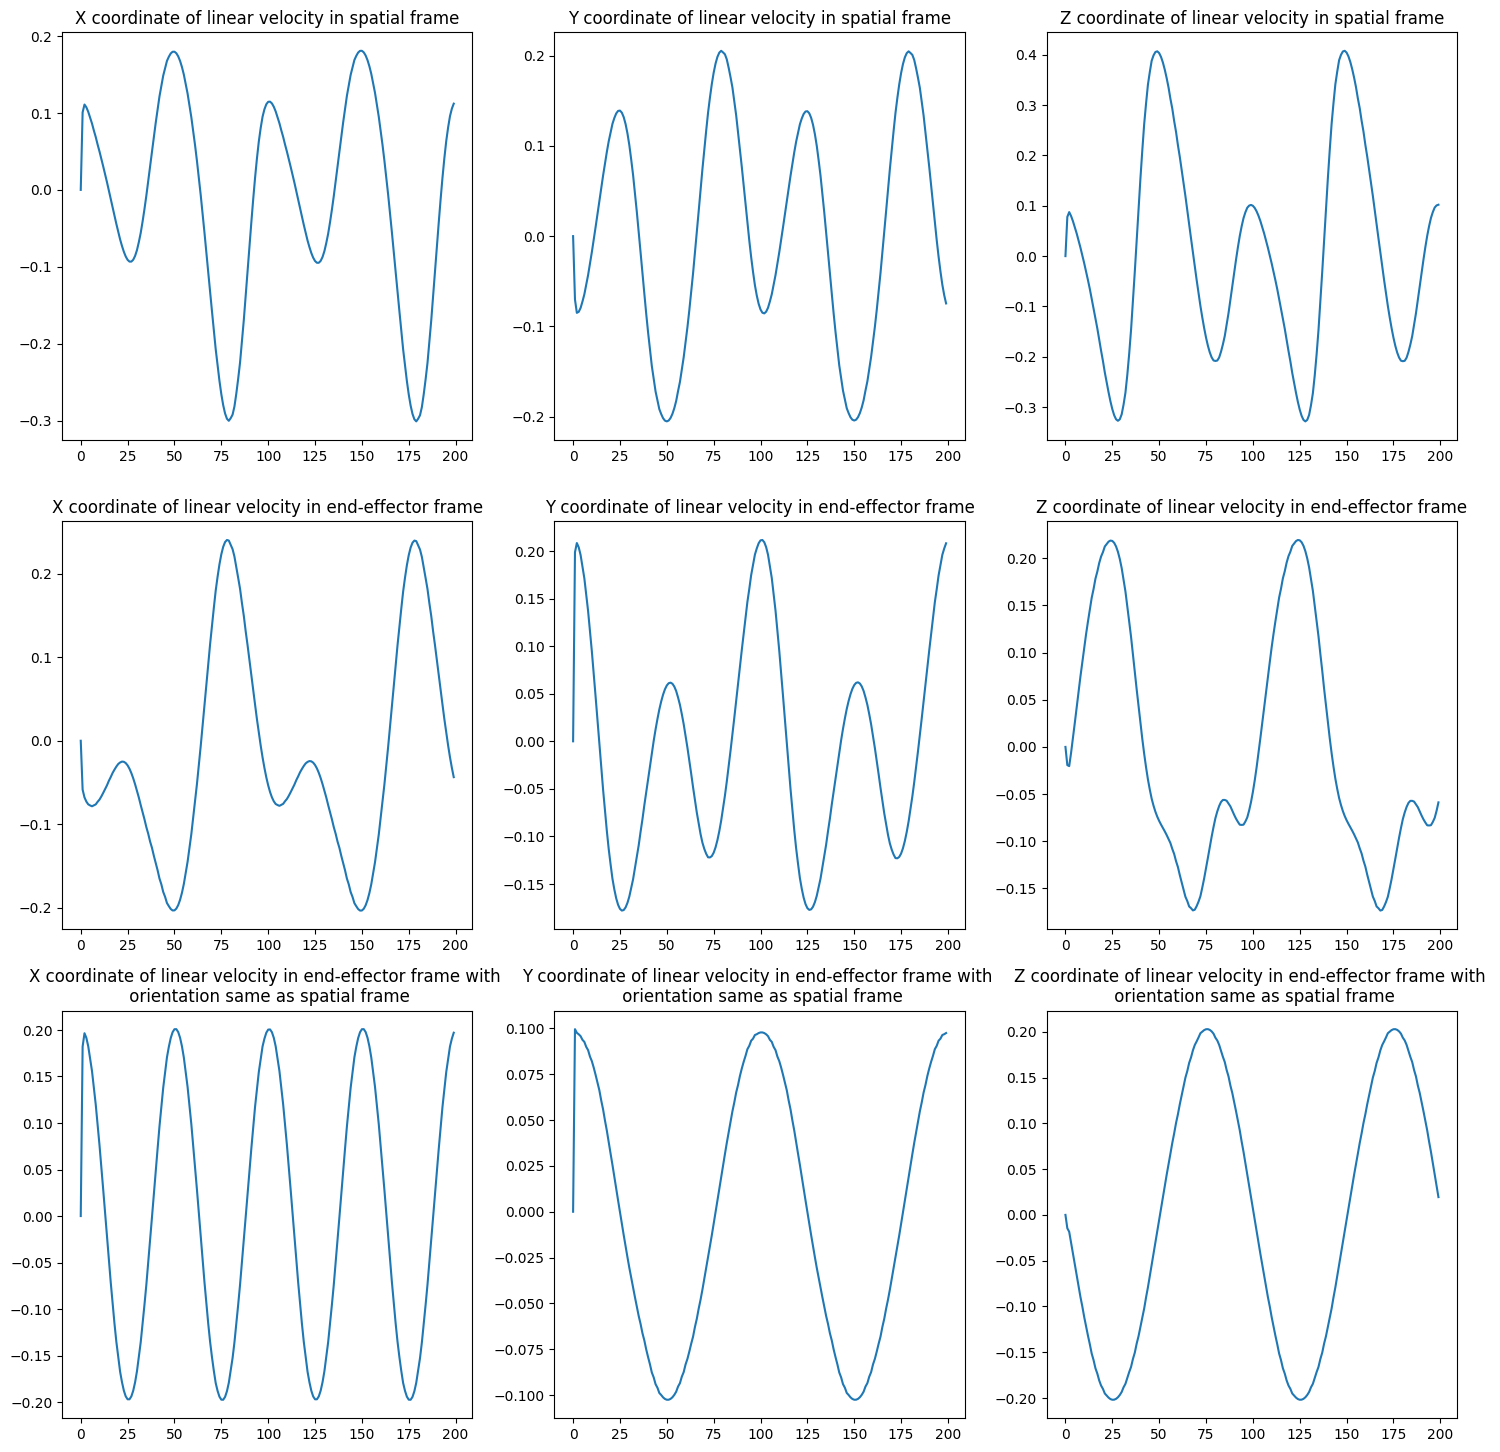

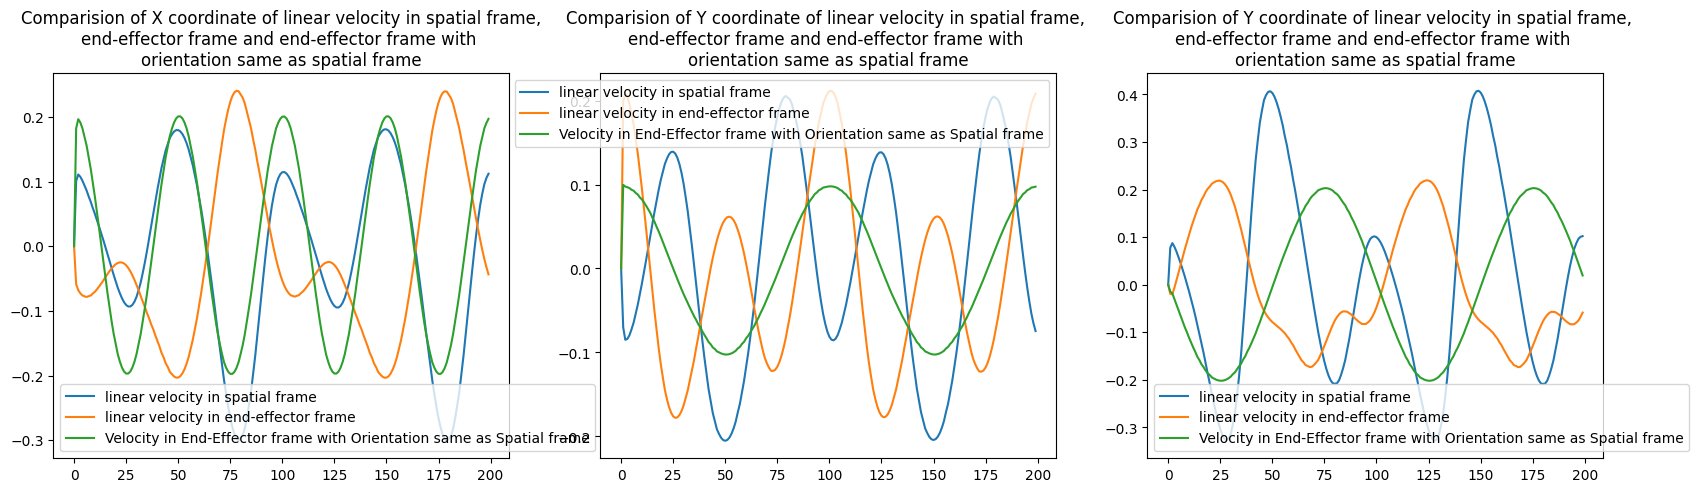

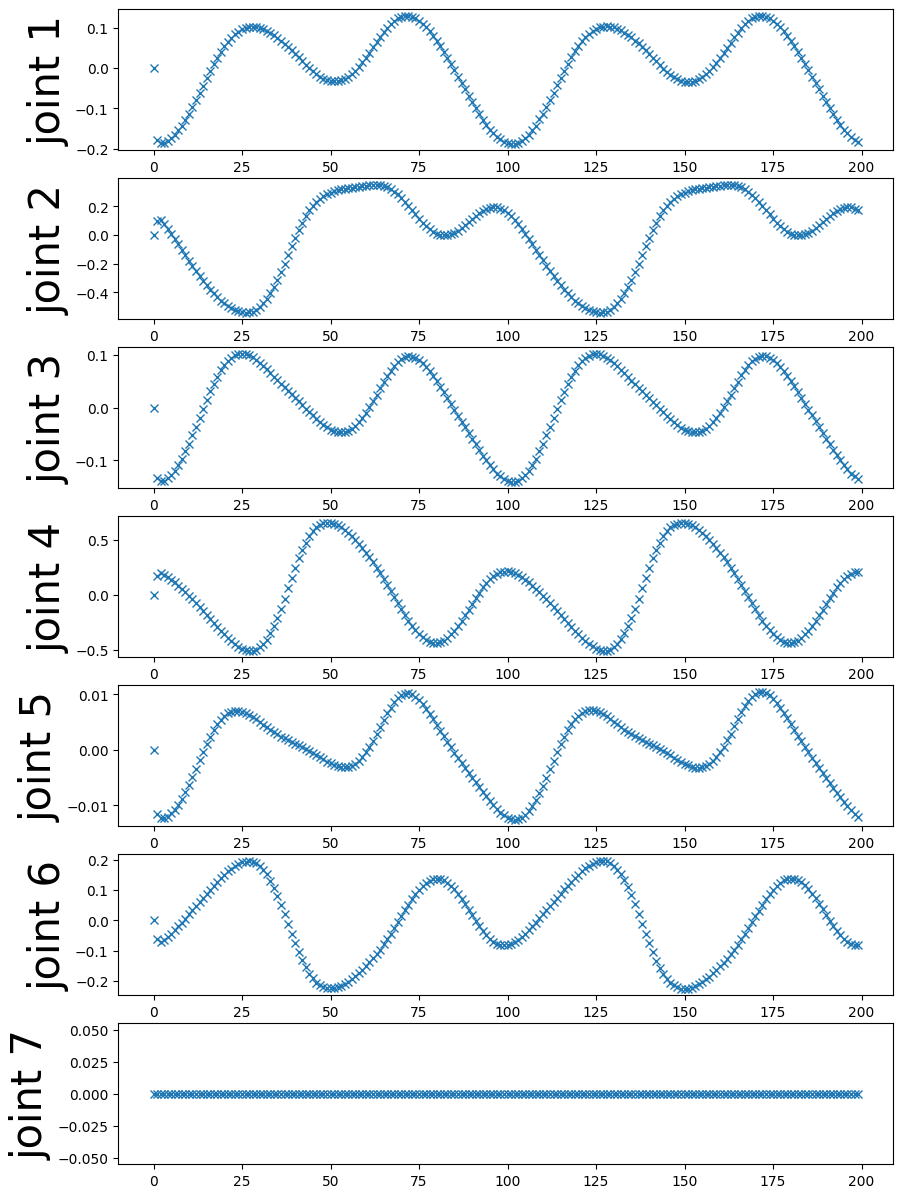

In [14]:
plt.figure(figsize = [18,18]) 
plt.subplot(3,3,1)  
plt.plot(Vsxyz[0,:])
plt.title('X coordinate of linear velocity in spatial frame') 
plt.subplot(3,3,2)  
plt.plot(Vsxyz[1,:])
plt.title('Y coordinate of linear velocity in spatial frame') 
plt.subplot(3,3,3)  
plt.plot(Vsxyz[2,:])
plt.title('Z coordinate of linear velocity in spatial frame') 
plt.subplot(3,3,4)  
plt.plot(Vbxyz[0,:])
plt.title('X coordinate of linear velocity in end-effector frame') 
plt.subplot(3,3,5)  
plt.plot(Vbxyz[1,:])
plt.title('Y coordinate of linear velocity in end-effector frame') 
plt.subplot(3,3,6)  
plt.plot(Vbxyz[2,:])
plt.title('Z coordinate of linear velocity in end-effector frame') 
plt.subplot(3,3,7)  
plt.plot(Vbexyz[0,:])
plt.title('X coordinate of linear velocity in end-effector frame with \n orientation same as spatial frame') 
plt.subplot(3,3,8)  
plt.plot(Vbexyz[1,:])
plt.title('Y coordinate of linear velocity in end-effector frame with \n orientation same as spatial frame') 
plt.subplot(3,3,9)  
plt.plot(Vbexyz[2,:])
plt.title('Z coordinate of linear velocity in end-effector frame with \n orientation same as spatial frame') 
plt.show()

plt.figure(figsize = [20,5]) 
plt.subplot(1,3,1)
plt.plot(Vsxyz[0,:])
plt.plot(Vbxyz[0,:])
plt.plot(Vbexyz[0,:])
plt.legend(['linear velocity in spatial frame', 'linear velocity in end-effector frame', 'Velocity in End-Effector frame with Orientation same as Spatial frame'])
plt.title('Comparision of X coordinate of linear velocity in spatial frame,\nend-effector frame and end-effector frame with \norientation same as spatial frame')
plt.subplot(1,3,2)
plt.plot(Vsxyz[1,:])
plt.plot(Vbxyz[1,:])
plt.plot(Vbexyz[1,:])
plt.legend(['linear velocity in spatial frame', 'linear velocity in end-effector frame', 'Velocity in End-Effector frame with Orientation same as Spatial frame'])
plt.title('Comparision of Y coordinate of linear velocity in spatial frame, \nend-effector frame and end-effector frame with \norientation same as spatial frame')
plt.subplot(1,3,3)
plt.plot(Vsxyz[2,:])
plt.plot(Vbxyz[2,:])
plt.plot(Vbexyz[2,:])
plt.legend(['linear velocity in spatial frame', 'linear velocity in end-effector frame', 'Velocity in End-Effector frame with Orientation same as Spatial frame'])
plt.title('Comparision of Y coordinate of linear velocity in spatial frame, \nend-effector frame and end-effector frame with \norientation same as spatial frame')
plt.show()

# now we plot the joint velocities for each joint (each cross correspond to one data point)
plt.figure(figsize=[10,15])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(joint_velocities[i,:], 'x', linewidth=4)
    plt.ylabel(f'joint {i+1}', fontsize=30)